In [5]:
# import modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import ccdproc

from ccdproc import ImageFileCollection as IFC
from astropy.nddata import CCDData
from astropy.modeling import models, fitting, powerlaws
from astropy import units as u
from astropy import constants as const

from scipy.stats import linregress
from scipy.optimize import curve_fit

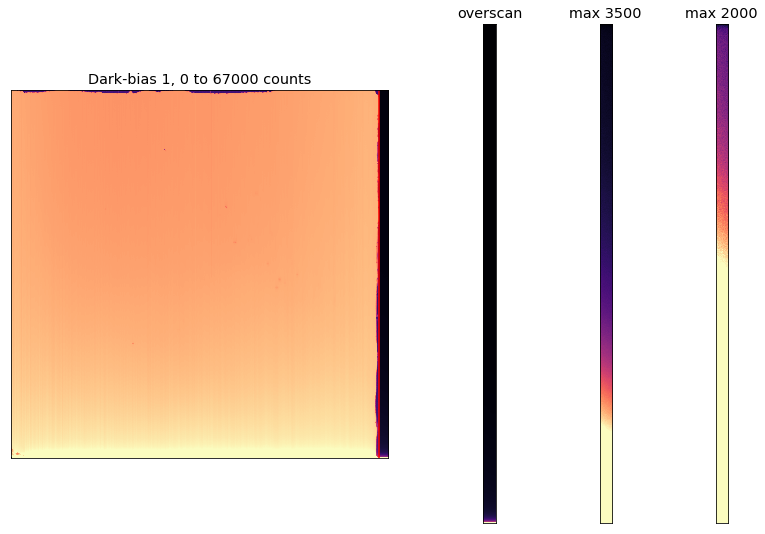

Bias of the 1. image:  2037.0 +/- 3678.3


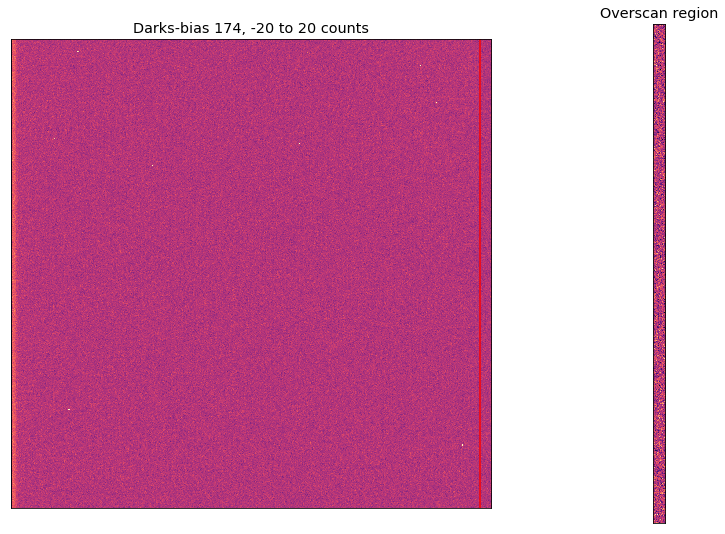

Bias of the last image:  1350.0 +/- 1.7


In [6]:
# from dark measurement read temperature and count median, standard deviation
# To read .fits file use IFC(<path_to_files>, glob_include = file name start*, keywords = interested key in header)
# The structure of a .fits file is Header Data Units(HDU)
# Each HDU contains .header (header information ~ key-value pair, labels of data) and .data 
# To get value of header information use IFC(...).values(<key>) or IFC(...).summary[<key>].data
# More info: https://ccdproc.readthedocs.io/en/latest/api/ccdproc.ImageFileCollection.html#ccdproc.ImageFileCollection.hdus
path = r".\Template Scripts\darks"
dark = IFC(path,glob_include='dark_*', keywords=['ccdtemp','datamedi','datastdv']) 
temp,med,stddev=np.asarray(dark.values("ccdtemp"))+273.15,np.asarray(dark.values("datamedi")),np.asarray(dark.values("datastdv"))
plt.rcParams.update({'font.size': 12})

# use program ds9 we read the overscan region(= bias region) for dark_0000.fits is about [1025:1050]
# a list of median bias values and the standard deviations in the overscan region
bias_med = []
bias_std = []

path = r".\Template Scripts\darks-bias"
for idx, hdu in enumerate(dark.hdus(save_with_name = "-bias",
                                    save_location = path, overwrite = True)):
    bias = CCDData(hdu.data[0:1024,1025:1050], unit="electron")
    bias_med.append(np.median(np.asarray(bias)))
    bias_std.append(np.std(np.asarray(bias)))
    # Correct each of the dark measurements with their corresponding median bias value
    hdu.data = hdu.data - np.median(np.asarray(bias))
    if idx == 0:
        # plot of the whole image
        pic = CCDData(hdu.data, unit="electron") # convert hdu(array) to pic(CCDData) first
        ax1 = plt.subplot2grid((1,7),(0,0),colspan=4)
        ax2 = plt.subplot2grid((1,7),(0,4))
        ax3 = plt.subplot2grid((1,7),(0,5))
        ax4 = plt.subplot2grid((1,7),(0,6))
        ax1.imshow(pic, cmap='magma', origin='lower left')
        ax1.axvline(x=1024,color='red')
        ax1.xaxis.set_major_locator(plt.NullLocator())
        ax1.yaxis.set_major_locator(plt.NullLocator())
        ax1.set_title("Dark-bias " + str(idx+1) + ", 0 to 67000 counts")
        # plot of overscan region
        ax2.imshow(bias, cmap='magma', origin='lower left')
        ax2.set_title("overscan")
        ax2.yaxis.set_major_locator(plt.NullLocator())
        ax2.xaxis.set_major_locator(plt.NullLocator())
        # more overscan
        ax3.imshow(bias, cmap='magma', origin='lower left',vmax=3500)
        ax3.set_title("max 3500")
        ax3.yaxis.set_major_locator(plt.NullLocator())
        ax3.xaxis.set_major_locator(plt.NullLocator())
        ax4.imshow(bias, cmap='magma', origin='lower left',vmax=2000)
        ax4.set_title("max 2000")
        ax4.yaxis.set_major_locator(plt.NullLocator())
        ax4.xaxis.set_major_locator(plt.NullLocator())
        plt.tight_layout()
        plt.gcf().set_size_inches(11.69, 8.27)
        plt.savefig(r".\pictures\darkbias1.png",)
        plt.show()
        print("Bias of the 1. image: ", bias_med[0], "+/-", round(bias_std[0],1))
    if idx == 173:
        # plot of the whole image
        picLast = CCDData(hdu.data, unit="electron") # convert hdu(array) to pic(CCDData) first
        ax1 = plt.subplot2grid((1,3),(0,0),colspan=2)
        ax2 = plt.subplot2grid((1,3),(0,2))
        ax1.imshow(picLast, cmap='magma', origin='lower left',vmin=-20, vmax=20)
        ax1.axvline(x=1024,color='red')
        ax1.yaxis.set_major_locator(plt.NullLocator())
        ax1.xaxis.set_major_locator(plt.NullLocator())
        ax1.set_title("Darks-bias " + str(idx+1) + ", -20 to 20 counts")
        # plot of overscan region
        ax2.imshow(bias, cmap='magma', origin='lower left')
        ax2.set_title("Overscan region")
        ax2.yaxis.set_major_locator(plt.NullLocator())
        ax2.xaxis.set_major_locator(plt.NullLocator())
        plt.tight_layout()
        plt.gcf().set_size_inches(11.69, 8.27)
        plt.savefig(r".\pictures\darkbias2.png",)
        plt.show()
        print("Bias of the last image: ", bias_med[-1], "+/-", round(bias_std[-1],1))

In [7]:
# Extract the median dark current values of the bias-subtracted FITS files of the dark measurements
path = r".\Template Scripts\darks-bias"
dark_no_bias = IFC(path,glob_include='dark_*', keywords=['datamedi', 'datastdv']) 
print("Bias of the 13. image: ", bias_med[12], "+/-", round(bias_std[12],1))
print("Bias of the 71. image: ", bias_med[70], "+/-", round(bias_std[70],1))
med_no_bias = []
stddev_no_bias = []
# use program ds9 we read the image region for dark_0000.fits is about (row[30:1014] colomn[0:1010])
for hdu in dark_no_bias.hdus():
    img = CCDData(hdu.data[0:1024,0:1020], unit="electron")
    med_no_bias.append(np.median(np.asarray(img)))
    stddev_no_bias.append(np.std(np.asarray(img)))

Bias of the 13. image:  1374.0 +/- 5.2
Bias of the 71. image:  1334.0 +/- 1.8


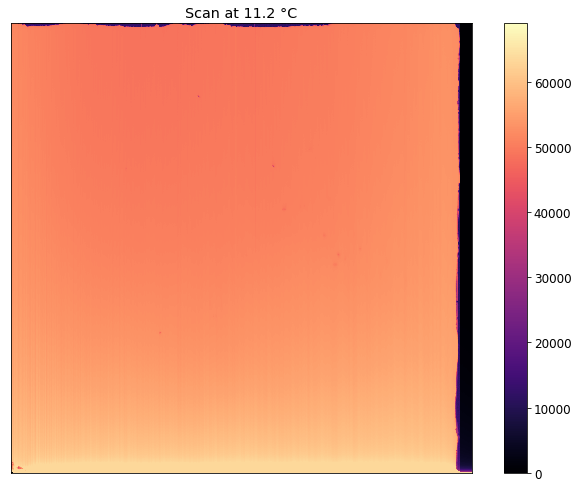

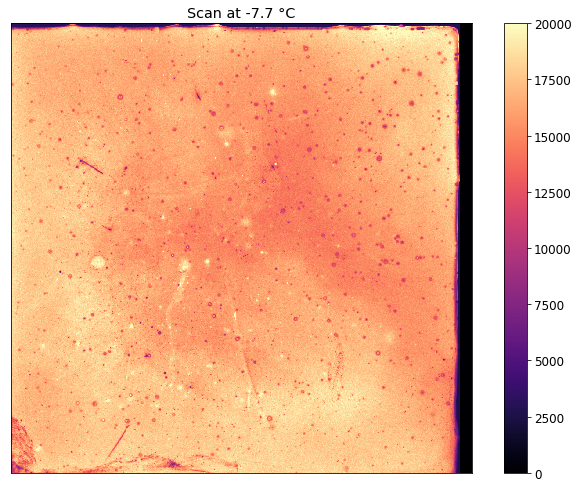

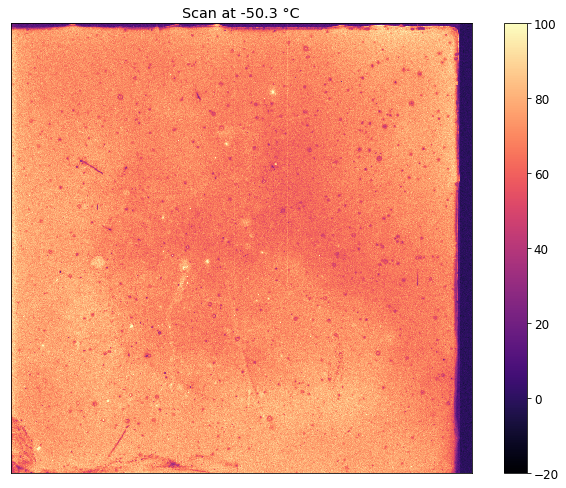

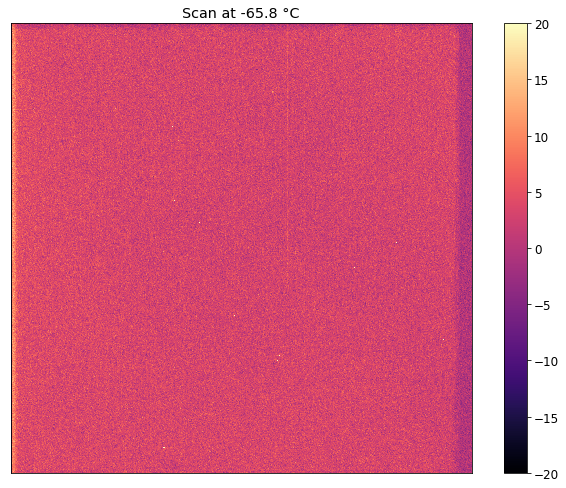

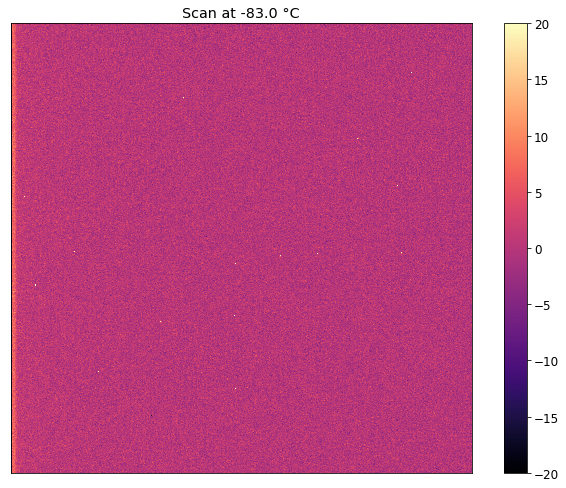

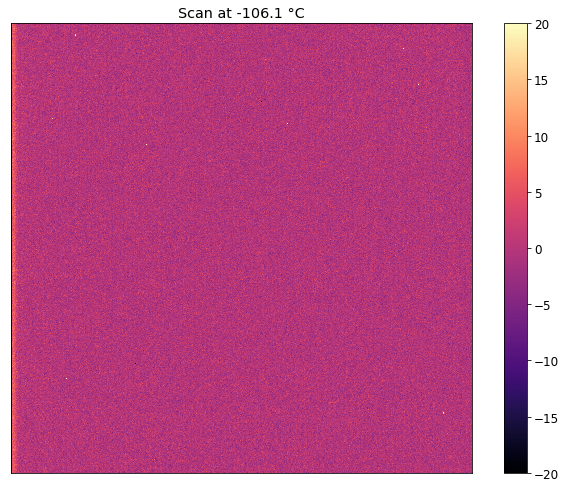

In [8]:
#Lots of pretty Pictures
for idx,hdu in enumerate(dark_no_bias.hdus()):
    h = 0
    if idx == 0: v = 69000
    if idx == 12: v = 20000
    if idx == 50: 
        h = -20
        v = 100
    if idx == 70: 
        v = 20
        h = -20
    if idx in [0,12,50,70]:
        pic = CCDData(hdu.data, unit='electron')
        plt.imshow(pic,cmap='magma',origin='lower',vmax=v,vmin=h)
        plt.tick_params(axis='both',which='both',bottom=False,left=False,
                top=False,right=False,labelbottom=False,labelleft=False)
        plt.colorbar()
        plt.title('Scan at '+str(round(temp[idx]-273.15,1))+' °C')
        plt.gcf().set_size_inches(11.69,8.27)
        plt.savefig(r".\pictures\PresentationDarks"+str(idx)+".png")
        plt.show()
    if idx in [100,173]:
        pic = CCDData(hdu.data, unit='electron')
        plt.imshow(pic,cmap='magma',origin='lower', vmin=-20, vmax=20)
        plt.tick_params(axis='both',which='both',bottom=False,left=False,
                top=False,right=False,labelbottom=False,labelleft=False)
        plt.colorbar()
        plt.title('Scan at '+str(round(temp[idx]-273.15,1))+' °C')
        plt.gcf().set_size_inches(11.69,8.27)
        plt.savefig(r".\pictures\PresentationDarks"+str(idx)+".png")
        plt.show()


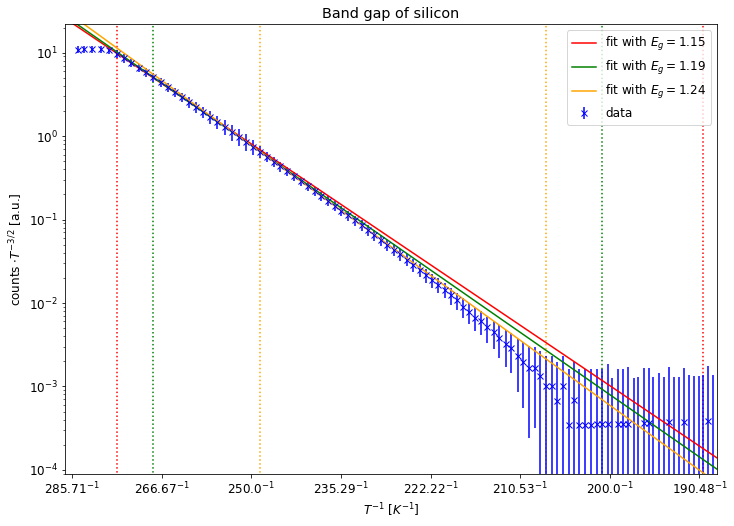

Parameter Errors are small: 0.003 0.003 0.003
Hence we use Error from the varying fitranges
Band gap of silicon =  1.19 +\- 0.04 eV
Literature value = 1.15 eV


In [9]:
# dark measurement analysis
# Verify the dependency according to eq. 14 by plotting the data and the theoretical curve 
def expon(x,A,k): 
    return A*np.exp(x*k)
xtemp = np.linspace(0.0034,0.00535,1000)

aa = 100
bb = 5
para, paraerr = curve_fit(expon, 1/temp[bb:aa], (med_no_bias*temp**(-3/2))[bb:aa], 
                      p0 = (3.2e10, -6000))
E_g1 = para[1]*u.K*(-2*const.k_B)
E_g_err1 = np.sqrt(paraerr[1][1])*u.K*(2*const.k_B)
plt.plot(xtemp, expon(xtemp, *para), label='fit with $E_g =$'+str(round(E_g1.to(u.eV).value,2)),
     color='red')
plt.vlines((1/temp[aa],1/temp[bb]),ymin=0, ymax=22,color='red',linestyles=':')


aa = 80
bb = 10
para, paraerr = curve_fit(expon, 1/temp[bb:aa], (med_no_bias*temp**(-3/2))[bb:aa], 
                          p0 = (3.2e10, -6000))
E_g2 = para[1]*u.K*(-2*const.k_B)
E_g_err2 = np.sqrt(paraerr[1][1])*u.K*(2*const.k_B)
plt.plot(xtemp, expon(xtemp, *para), label='fit with $E_g =$'+str(round(E_g2.to(u.eV).value,2)),
         color='green')
plt.vlines((1/temp[aa],1/temp[bb]),ymin=0, ymax=22,color='green',linestyles=':')

aa = 70
bb = 25
para, paraerr = curve_fit(expon, 1/temp[bb:aa], (med_no_bias*temp**(-3/2))[bb:aa], 
                          p0 = (3.2e10, -6000))
E_g3 = para[1]*u.K*(-2*const.k_B)
E_g_err3 = np.sqrt(paraerr[1][1])*u.K*(2*const.k_B)
plt.plot(xtemp, expon(xtemp, *para), label='fit with $E_g =$'+str(round(E_g3.to(u.eV).value,2)),
         color='orange')
plt.vlines((1/temp[aa],1/temp[bb]),ymin=0, ymax=22,color='orange',linestyles=':')
plt.errorbar(1/temp[0:103], (med_no_bias*temp**(-3/2))[0:103],
    yerr=(stddev_no_bias*temp**(-3/2))[0:103],marker='x', ls='none', color='blue', label = 'data')

plt.xlabel("$T^{-1}$ [$K^{-1}$]")
plt.ylabel("counts $\cdot T^{-3/2}$ [a.u.]")
plt.yscale('log')
plt.title("Band gap of silicon")
locs, label = plt.xticks()
label = [str(round(1/float(item),2))+"$^{-1}$" for item in locs]
plt.xticks(locs, label)
plt.axis([0.00348, 0.00530, 9e-5, 22])
plt.legend()

plt.gcf().set_size_inches(11.69, 8.27)
plt.savefig(r".\pictures\BandGap.png")
plt.show()
# Determine the band gap of the detector chip by fitting the dependency.
print("Parameter Errors are small:",round(E_g_err1.to(u.eV).value,3),round(E_g_err2.to(u.eV).value,3),
     round(E_g_err3.to(u.eV).value,3))
print("Hence we use Error from the varying fitranges")
print("Band gap of silicon = ",round(E_g2.to(u.eV).value,2),"+\-",
      round(0.5*(E_g2.to(u.eV).value-E_g1.to(u.eV).value+E_g3.to(u.eV).value-E_g2.to(u.eV).value),2), 
      "eV")
print("Literature value = 1.15 eV")

#TODO: Show Fitranges in vlines dotted

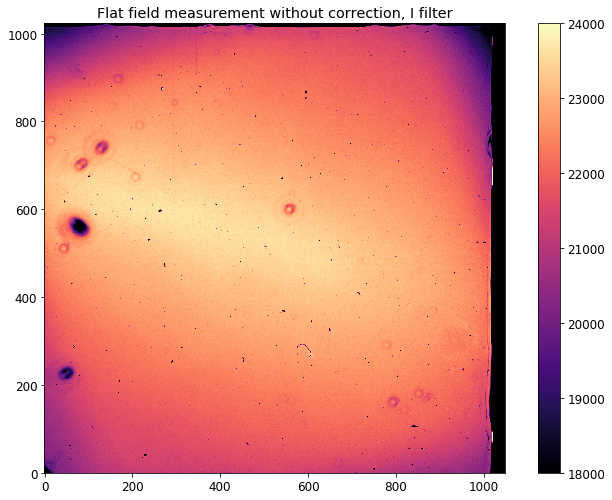

C:\Users\Color\Documents\Anaconda\lib\site-packages\astropy\units\quantity.py:461: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Color\Documents\Anaconda\lib\site-packages\astropy\units\quantity.py:461: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


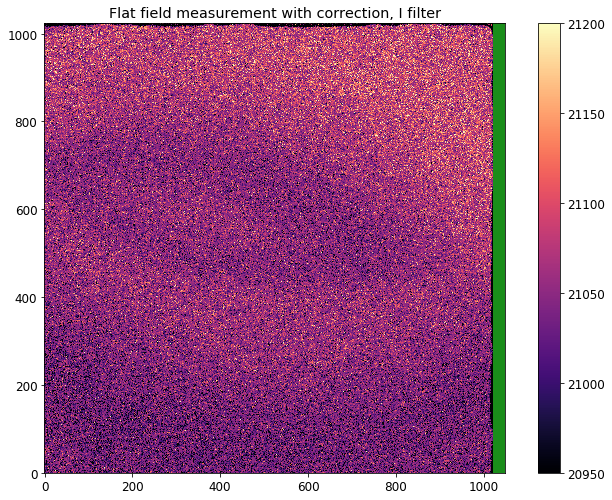

V Filter 0.009074488216067435
R Filter 0.009559623051830373
I Filter 0.010023276803952307


In [10]:
# read flat field measurement
path = r".\Template Scripts\flats"
flat_I = IFC(path,glob_include='flat_I_*',glob_exclude='*test*', keywords=['exptime', 'ccdtemp'])
flat_V = IFC(path,glob_include='flat_V_*', keywords=['exptime', 'ccdtemp'])
flat_R = IFC(path,glob_include='flat_R_*',glob_exclude='*test*', keywords=['exptime', 'ccdtemp'])

lower_bound = 211

# I filter
flat_list = []
for idx, hdu in enumerate(flat_I.hdus()):
    dat = CCDData(hdu.data, unit="electron")
    if idx == 0:
        plt.imshow(dat, cmap='magma', origin='lower', vmax=24000, vmin=18000)
        plt.title("Flat field measurement without correction, I filter")
        plt.colorbar()
        plt.gcf().set_size_inches(11.69, 8.27)
        plt.savefig(r".\pictures\FlatIFits.png",)
        plt.show()
    # subtract the bias from the individual flat-field images
    bias = np.median(CCDData(hdu.data[0:1024,1025:1050], unit="electron"))
    dat.data = dat.data - bias
    flat_list.append(dat)
    
# Combine the individual flat-field images to a single image (the master flatfield) 
read_out_I = np.asarray(ccdproc.Combiner(flat_list).median_combine())
read_out_I[read_out_I < lower_bound] = 0
# normalize the master flat-field by dividing it by its median (why?)
master_flat_I = read_out_I/np.median(read_out_I)

for idx, hdu in enumerate(flat_I.hdus()):
    dat = CCDData(hdu.data, unit="electron")
    dat.data = dat.data - bias
    # Perform a flat-field correction (i.e., divide the image by the normalized master flat-field)
    dat.data = dat.divide(master_flat_I)
    current_cmap = cm.get_cmap('magma')
    current_cmap.set_bad(color='green',alpha=0.9)
    plt.imshow(dat, cmap='magma',origin='lower', vmax=21200,vmin=20950)
    plt.title("Flat field measurement with correction, I filter")
    plt.colorbar()
    plt.gcf().set_size_inches(11.69, 8.27)
    plt.savefig(r".\pictures\FlatIFitsMasterCorrected.png",)
    plt.show()
    break  

# V filter
flat_list = []
for idx, hdu in enumerate(flat_V.hdus()):
    dat = CCDData(hdu.data, unit="electron")
    # subtract the bias from the individual flat-field images
    bias = np.median(CCDData(hdu.data[0:1024,1025:1050], unit="electron"))
    dat.data = dat.data - bias
    flat_list.append(dat)
    
# Combine the individual flat-field images to a single image (the master flatfield)
read_out_V = np.asarray(ccdproc.Combiner(flat_list).median_combine())
read_out_V[read_out_V < lower_bound] = 0
# normalize the master flat-field by dividing it by its median (why?)
master_flat_V = read_out_V/np.median(read_out_V)

# R filter
flat_list = []
for idx, hdu in enumerate(flat_R.hdus()):
    dat = CCDData(hdu.data, unit="electron")
    # subtract the bias from the individual flat-field images
    bias = np.median(CCDData(hdu.data[0:1024,1025:1050], unit="electron"))
    dat.data = dat.data - bias
    flat_list.append(dat)
    
# Combine the individual flat-field images to a single image (the master flatfield)
read_out_R = np.asarray(ccdproc.Combiner(flat_list).median_combine())
read_out_R[read_out_R < lower_bound] = 0
# normalize the master flat-field by dividing it by its median (why?)
master_flat_R = read_out_R/np.median(read_out_R)

print("V Filter",lower_bound/np.median(read_out_V))
print("R Filter",lower_bound/np.median(read_out_R))
print("I Filter",lower_bound/np.median(read_out_I))

C:\Users\Color\Documents\Anaconda\lib\site-packages\matplotlib\figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


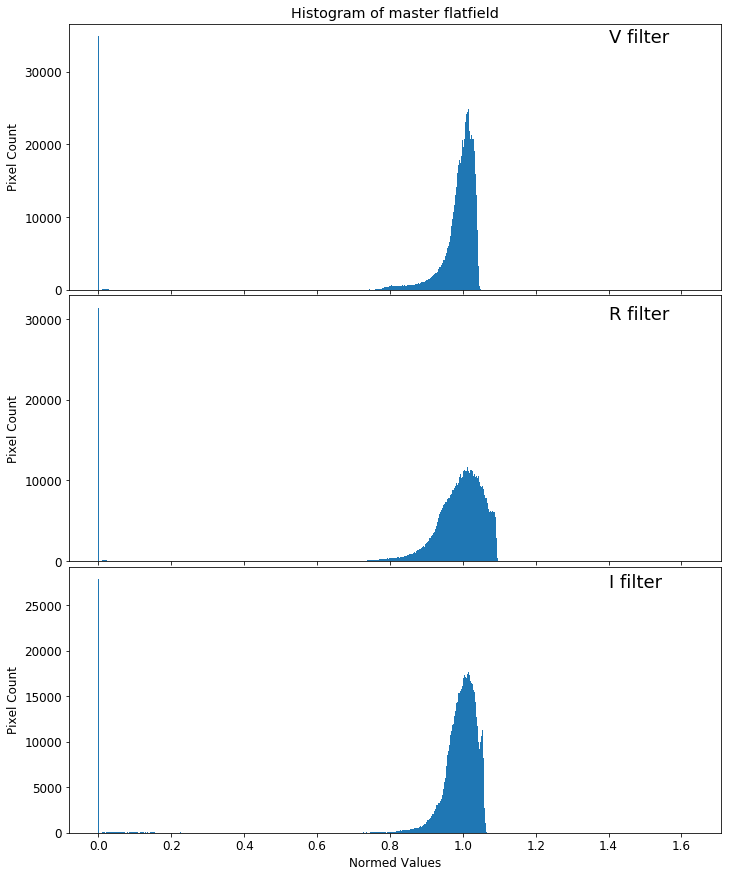

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, gridspec_kw={'hspace': 0.02})
plt.rcParams.update({'font.size': 22})

# obtain a histogram for V master flatfield
nV, binsV, patchesV = ax1.hist(master_flat_V.ravel(), bins='sqrt')
ax1.title.set_text("Histogram of master flatfield")
ax1.text(1.4,3.4e4,"V filter",fontsize=18)
ax1.set_ylabel('Pixel Count')

# obtain a histogram for R master flatfield
nR, binsR, patchesR = ax2.hist(master_flat_R.ravel(), bins='sqrt')
ax2.text(1.4,3e4,"R filter",fontsize=18)
ax2.set_ylabel('Pixel Count')

# obtain a histogram for I master flatfield
nI, binsI, patchesI = ax3.hist(master_flat_I.ravel(), bins='sqrt')
ax3.text(1.4,2.7e4,"I filter",fontsize=18)
ax3.set_ylabel('Pixel Count')

plt.xlabel('Normed Values')
plt.gcf().set_size_inches(11.69, 8.27*1.8)
plt.tight_layout()
plt.savefig(r".\pictures\FlatHist.png",dpi=70)
plt.show()

C:\Users\Color\Documents\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


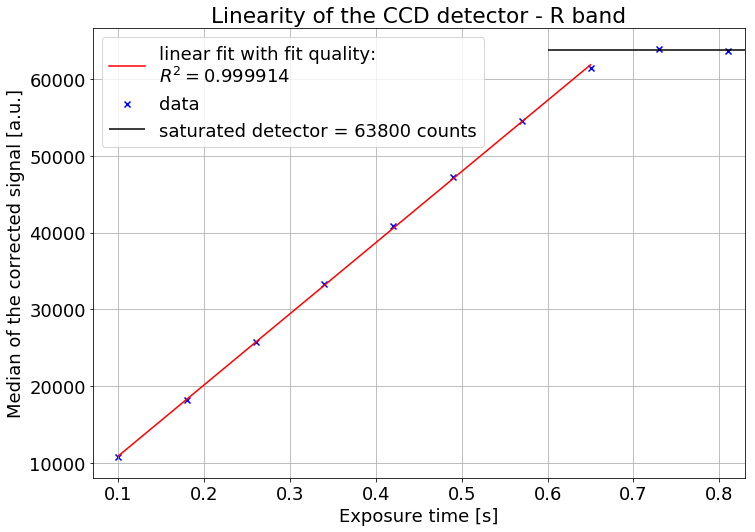

In [12]:
# from linearity measurement read exposure time 
path = r".\Template Scripts\linearity"
lin = IFC(path,glob_include='linearity_R_*',keywords=['exptime'])
exptime = lin.summary['exptime'].data
plt.rcParams.update({'font.size': 18})

lin_med_ff = []
lin_stddev_ff = []

for idx, hdu in enumerate(lin.hdus()):
    dat = CCDData(hdu.data, unit="electron")
    # bias correction
    bias = np.median(CCDData(hdu.data[0:1024,1025:1050], unit="electron"))
    dat.data = dat.data - bias
    # flat field correction
    dat.data = dat.divide(master_flat_R)
    lin_med_ff.append(np.nanmedian(dat.data))
    lin_stddev_ff.append(np.nanstd(dat.data))

# Verify the linearity of the chip by plotting the signal integration time
plt.scatter(exptime, lin_med_ff, marker='x', color='blue', label = 'data')
# Determine the deviation from a perfect linear relationship and specify the intensity at saturation 
slope, intercept, r_value, p_value, std_err = linregress(exptime[:-2], lin_med_ff[:-2])
plt.plot(exptime[:-2], slope*exptime[:-2]+intercept,color='red', label='\n'.join([
    "linear fit with fit quality:",
    "$R^2 = $"+str(round(r_value,6))]))
plt.hlines(np.average(lin_med_ff[-2:]),xmin=0.6,xmax=1, label='saturated detector = '+
          str(int(round(np.average(lin_med_ff[-2:]),-2)))+" counts")
plt.title("Linearity of the CCD detector - R band")
plt.ylabel("Median of the corrected signal [a.u.]")
plt.xlabel("Exposure time [s]")
plt.grid()
plt.legend()
plt.xlim(0.07,0.83)
plt.gcf().set_size_inches(11.69, 8.27)
plt.savefig(r".\pictures\LinearityRFilter.png",)
plt.show()

C:\Users\Color\Documents\Anaconda\lib\site-packages\numpy\core\_methods.py:107: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True)


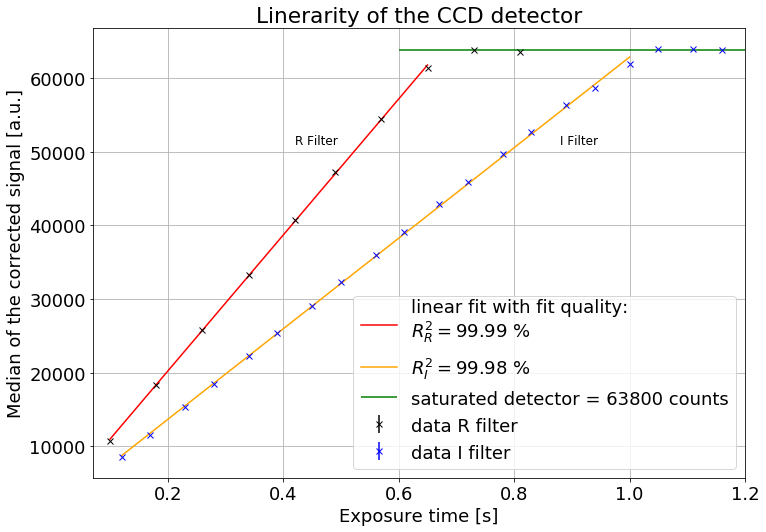

In [13]:
# from sensitivity measurement read exposure time 
path = r".\Template Scripts\sensitivity"
sen = IFC(path,glob_include='sensitivity_I_1_*',keywords=['exptime'])
sen2 = IFC(path,glob_include='sensitivity_I_2_*',keywords=['exptime'])
exptime_sen = sen.summary['exptime'].data
plt.rcParams.update({'font.size': 18})

sen_med_ff = []
sen_stddev_ff = []

for idx, hdu in enumerate(sen.hdus()):
    dat = CCDData(hdu.data, unit="electron")
    # bias correction
    bias = np.median(CCDData(hdu.data[0:1024,1025:1050], unit="electron"))
    dat.data = dat.data - bias
    # flat field correction
    dat.data = dat.divide(master_flat_I)
    sen_med_ff.append(np.nanmedian(dat.data))
    sen_stddev_ff.append(np.std(dat.data))

# Verify the linearity of the chip by plotting the signal  against integration time
plt.errorbar(exptime, lin_med_ff, yerr=lin_stddev_ff, linestyle='None', marker='x',
             color='black',label='data R filter')
plt.errorbar(exptime_sen, sen_med_ff, yerr=sen_stddev_ff, linestyle='None', marker='x',
             color='blue', label='data I filter')

# Determine the deviation from a perfect linear relationship and specify the intensity at saturation
slope, intercept, r_value, p_value, std_err = linregress(exptime[:-2], lin_med_ff[:-2])
plt.plot(exptime[:-2], slope*exptime[:-2]+intercept,color='red', label='\n'.join([
    "linear fit with fit quality:",
    "$R^2_R = $"+str(round(r_value,4)*100)+" %"]))

slope, intercept, r_value, p_value, std_err = linregress(exptime_sen[:-3], sen_med_ff[:-3])
plt.plot(exptime_sen[:-3], slope*exptime_sen[:-3]+intercept,color='orange', label='\n'.join([
    #"linear fit with fit quality:",
    "$R^2_I = $"+str(round(r_value,4)*100)+" %"]))

lin_avg = np.average(lin_med_ff[-2:])
sen_avg = np.average(sen_med_ff[-3:])
saturated = 0.5*(lin_avg+sen_avg)
plt.hlines(saturated,xmin=0.6,xmax=1.3, color='green',label='saturated detector = '
           +str(int(round(saturated,-2)))+" counts")
plt.legend(loc='lower right')
plt.text(0.42,5.1e4,"R Filter",fontsize=12)
plt.text(0.88,5.1e4,"I Filter",fontsize=12)
plt.grid()
plt.xlim(0.07,1.2)
plt.title("Linerarity of the CCD detector")
plt.ylabel("Median of the corrected signal [a.u.]")
plt.xlabel("Exposure time [s]")
plt.gcf().set_size_inches(11.69, 8.27)
plt.savefig(r".\pictures\Linearity.png",)
plt.show()

Let's take the seventh image Pair (_0006) for example:
the total noise:  264.3
the difference noise:  75.9
the read-out noise:  2.1
the photon noise:  53.6
the PRNU noise:  258.8


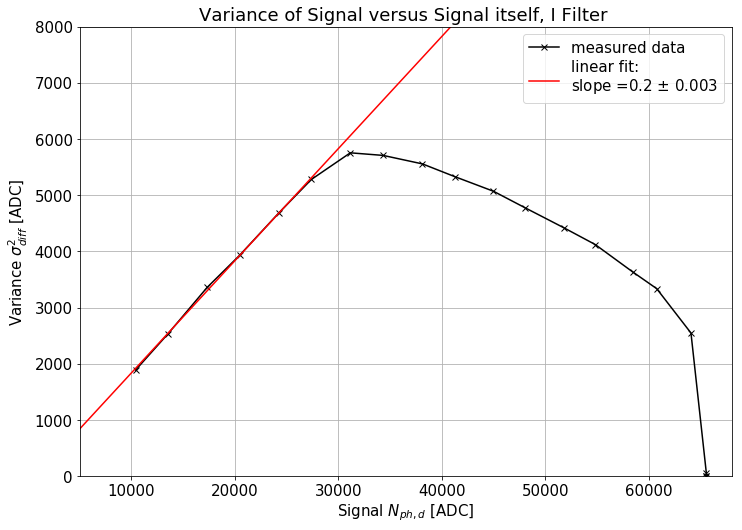

gain and read out noise with eq (23)
 k =  10.02  +/-  0.13
 read out noise =  8.96  +/-  2.85

Let's consider the same picture as above (_0006): 
 N =  31156 
 sig**2 =  2872.73 

with eq. 19 we calculate the gain to: 
 k = 10.85  +/-  0.03


In [14]:
# Sensitivity of the detector and noise properties
# TODO: not so sure about that part
ita = 1. # the quantum efficiency, assuming = 1
kappa = 5. # electron seneitivity
f_PRNU = 0.01
xfit = np.linspace(500,6.8e4,100)
plt.rcParams.update({'font.size': 15})

# in the following sig_* meaning (sig_*)^2
N_e_d = []
N_e_d2 = []
sig_diff_list = []

for idx, (hdu, hdu2) in enumerate(zip(sen.hdus(),sen2.hdus())):
    dat = CCDData(hdu.data, unit="electron")
    dat2 = CCDData(hdu2.data, unit="electron")
    # subtract the signal of one image from the other
    diffdat = dat.subtract(dat2)
    # Choose at least a 200 x 200 pixel region that is uniformly illuminated near the center
    # in our case x[303:502] y[296:495], see pic "sensitivity_region"
    # extract median signal within the chosen regions
    N_e_d.append(np.median(dat[303:502, 296:495]))
    N_e_d2.append(np.median(dat2[303:502, 296:495]))
    sig_diff_list.append(np.std(diffdat[303:502, 296:495]))
    # Find and discuss the photon noise, the read-out noise, and the PRNU noise for one flat image
    if idx==6:
        print("Let's take the seventh image Pair (_0006) for example:")
        sig_tot1 = np.std(dat.data[303:502, 296:495])
        sig_tot2 = np.std(dat2.data[303:502, 296:495])
        sig_tot = 0.5*(sig_tot1 + sig_tot2)
        print("the total noise: ", round(sig_tot,1))
        print("the difference noise: ", round(sig_diff_list[6],1),)
        sig_R = np.std(dat.data[170:650,1025:1050])
        print("the read-out noise: ", round(sig_R,1))
        sig_diff = np.std(diffdat[303:502,296:495])
        sig_ed_ver1 = np.sqrt(-sig_R**2+0.5*sig_diff**2)
        print("the photon noise: ", round(sig_ed_ver1,1))
        sig_prnu = np.sqrt(-sig_R**2-sig_ed_ver1**2+sig_tot**2)
        print("the PRNU noise: ", round(sig_prnu,1))

N_e_d = np.asarray(N_e_d)
N_e_d2 = np.asarray(N_e_d2)
N_avg = 0.5*(N_e_d+N_e_d2)
sig_diff_list = np.asarray(sig_diff_list)

def linear(x,a,b):
    return a*x+b

para,pcov = curve_fit(linear, N_avg[:6], sig_diff_list[:6]**2,p0=[0.2,0])

#plt.vlines(N_avg[6],ymin=0,ymax=6e3)
plt.plot(N_avg,sig_diff_list**2,'kx-', label ='measured data' )
plt.plot(xfit, linear(xfit,*para),'r-', label='\n'.join([
    "linear fit: ",
    "slope ="+str(round(para[0],3))+" $\pm$ "+str(round(np.sqrt(pcov[0,0]),3))]))
#    "$b$ ="+str(round(para[1],3))+" $\pm$ "+str(round(np.sqrt(pcov[1,1]),3))]))
plt.title('Variance of Signal versus Signal itself, I Filter ')
plt.legend()
plt.xlabel('Signal $N_{ph,d}$ [ADC]')
plt.ylabel('Variance $\sigma^{2}_{diff}$ [ADC]')
plt.xlim(0.5e4,6.8e4)
plt.ylim(0,8e3)
plt.grid()
plt.gcf().set_size_inches(11.69, 8.27)
plt.savefig(r".\pictures\Noise.png",)
plt.show()

print("gain and read out noise with eq (23)\n k = ",str(round(2/para[0],2))," +/- "
      ,str(round(2*np.sqrt(pcov[0,0])/(para[0])**2,2)))
print(" read out noise = ",str(round(np.sqrt(-para[1]/2),2))," +/- "
      ,str(round(np.sqrt(pcov[1,1])/(2*np.sqrt(-para[1]/2)),2)))

print('\nLet\'s consider the same picture as above (_0006): \n N = ', int(round(N_avg[6],0)),
      '\n sig**2 = ',round(sig_ed_ver1**2,2),'\n\nwith eq. 19 we calculate the gain to: \n k =',
      round(N_avg[6]/sig_ed_ver1**2,2)," +/- ",round(sig_diff_list[6]/sig_ed_ver1**2,2))

# TODO: Check out Read out noise for one _0006 --> Area not clean?

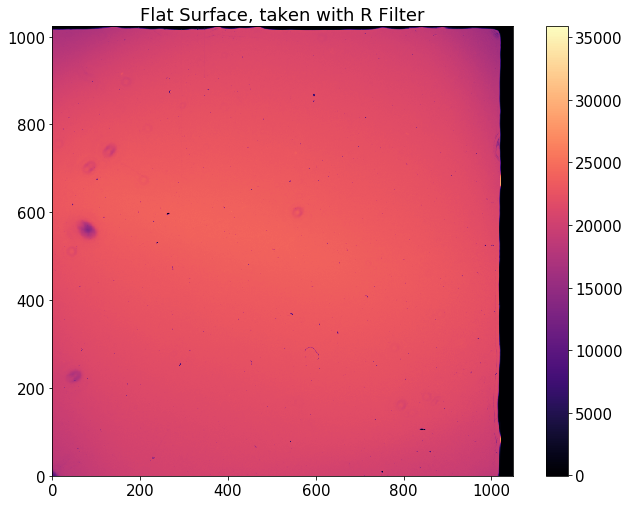

In [15]:
start = flat_list[2]
plt.imshow(np.asarray(start),origin='lower',cmap='magma')
plt.colorbar()
plt.title('Flat Surface, taken with R Filter')
plt.gcf().set_size_inches(11.69, 8.27)
plt.savefig(r".\pictures\PresentationStart.png",)
plt.show()